## 1. Problem Analysis

The test calls for the prediction of a binary flag from a set of data of middling size with multiple features of different types. Since it's a classification task, we will need some specific machine-learning algorithms from the `scikit-learn` package (discussed below) and we will test them against each other. The performance metrics for the evaluation will be the staples of classification problems, but we will let the context of the problem guide our appraisal of their weight.

## 2. Data Processing

Let's set up the python environment by importing the requisite packages:

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(
    context='talk',
    style='whitegrid',
    palette='muted'
)
plt.rcParams["figure.figsize"] = (16,9)

from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer

from sklearn.ensemble import ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline

### Cleanup

After a brief inspection of the training file, we import the data with some minor corrections for boolean parameters:

In [2]:
raw_train=pd.read_csv('train_auto.csv',
                        index_col='INDEX',
                        false_values=['no', 'No', 'NO', 'z_No'],
                        true_values=['yes', 'Yes', 'YES']
                    )

In [3]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8161 entries, 1 to 10302
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  8161 non-null   int64  
 1   TARGET_AMT   8161 non-null   float64
 2   KIDSDRIV     8161 non-null   int64  
 3   AGE          8155 non-null   float64
 4   HOMEKIDS     8161 non-null   int64  
 5   YOJ          7707 non-null   float64
 6   INCOME       7716 non-null   object 
 7   PARENT1      8161 non-null   bool   
 8   HOME_VAL     7697 non-null   object 
 9   MSTATUS      8161 non-null   bool   
 10  SEX          8161 non-null   object 
 11  EDUCATION    8161 non-null   object 
 12  JOB          7635 non-null   object 
 13  TRAVTIME     8161 non-null   int64  
 14  CAR_USE      8161 non-null   object 
 15  BLUEBOOK     8161 non-null   object 
 16  TIF          8161 non-null   int64  
 17  CAR_TYPE     8161 non-null   object 
 18  RED_CAR      8161 non-null   bool   
 19  OLDCL

From the start, we can see there are quite a few missing entries, so we will have to address that. Most columns have clear meaning (income, age, sex, job); other are more obscure (MVR_PST, TIF). Some columns are booleans, some are categories, some are numerical but with different types. As discussed above, we can drop the TARGET_AMT as is outside of the scope of this analysis and reserve TARGET_FLAG  as target vector for the training:

In [4]:
train_set=raw_train.drop(columns='TARGET_AMT')       

target_flags=train_set['TARGET_FLAG'].astype('bool').to_numpy()    #Copy the flags to an array 

train_set.head()                                                

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,
1,0,0,60.0,0,11.0,"$67,349",False,$0,False,M,...,"$14,230",11,Minivan,True,"$4,461",2,False,3,18.0,Highly Urban/ Urban
2,0,0,43.0,0,11.0,"$91,449",False,"$257,252",False,M,...,"$14,940",1,Minivan,True,$0,0,False,0,1.0,Highly Urban/ Urban
4,0,0,35.0,1,10.0,"$16,039",False,"$124,191",True,z_F,...,"$4,010",4,z_SUV,False,"$38,690",2,False,3,10.0,Highly Urban/ Urban
5,0,0,51.0,0,14.0,NaN,False,"$306,251",True,M,...,"$15,440",7,Minivan,True,$0,0,False,0,6.0,Highly Urban/ Urban
6,0,0,50.0,0,NaN,"$114,986",False,"$243,925",True,z_F,...,"$18,000",1,z_SUV,False,"$19,217",2,True,3,17.0,Highly Urban/ Urban


Next we should address the fact that many values in 'object' columns have, for some reason, a 'z_' prepended. Also, maybe because of the dollar symbol, entries in columns that should represent financial values ('INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM') have been erroneously filed as objects, instead of numerical values. Let's clean them up:

In [5]:
#Replaces z_ or $ and separators with nothing in object columns through an anonymous function
for sym in ['z_', '$', ',']:
    train_set = train_set.apply(lambda x: x.str.replace(sym, '') if x.dtype == object else x)

#Transforms financial columns to a numerical value
to_numerical=['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']

for clmn in to_numerical:
    train_set[clmn]=train_set[clmn].astype('float')

<ipython-input-5-d91363eedf33>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  train_set = train_set.apply(lambda x: x.str.replace(sym, '') if x.dtype == object else x)


The columns CLM_FREQ, HOMEKIDS and KIDSDRIV, are integers but serve better as categorical values; the same is true for the remaining string columns, such as 'SEX', 'JOB' or 'CAR_TYPE':

In [6]:
to_category=['KIDSDRIV','HOMEKIDS','CLM_FREQ','SEX','JOB','EDUCATION','CAR_TYPE','CAR_USE','URBANICITY']

for clmn in to_category:
    train_set[clmn]=train_set[clmn].astype('category')

# Consolidate the column dtypes
train_set=train_set.convert_dtypes()

train_set.head()


,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,
1,0,0,60,0,11,67349,False,0,False,M,...,14230,11,Minivan,True,4461,2,False,3,18,Highly Urban/ Urban
2,0,0,43,0,11,91449,False,257252,False,M,...,14940,1,Minivan,True,0,0,False,0,1,Highly Urban/ Urban
4,0,0,35,1,10,16039,False,124191,True,F,...,4010,4,SUV,False,38690,2,False,3,10,Highly Urban/ Urban
5,0,0,51,0,14,<NA>,False,306251,True,M,...,15440,7,Minivan,True,0,0,False,0,6,Highly Urban/ Urban
6,0,0,50,0,<NA>,114986,False,243925,True,F,...,18000,1,SUV,False,19217,2,True,3,17,Highly Urban/ Urban


In [7]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8161 entries, 1 to 10302
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   TARGET_FLAG  8161 non-null   Int64   
 1   KIDSDRIV     8161 non-null   category
 2   AGE          8155 non-null   Int64   
 3   HOMEKIDS     8161 non-null   category
 4   YOJ          7707 non-null   Int64   
 5   INCOME       7716 non-null   Int64   
 6   PARENT1      8161 non-null   boolean 
 7   HOME_VAL     7697 non-null   Int64   
 8   MSTATUS      8161 non-null   boolean 
 9   SEX          8161 non-null   category
 10  EDUCATION    8161 non-null   category
 11  JOB          7635 non-null   category
 12  TRAVTIME     8161 non-null   Int64   
 13  CAR_USE      8161 non-null   category
 14  BLUEBOOK     8161 non-null   Int64   
 15  TIF          8161 non-null   Int64   
 16  CAR_TYPE     8161 non-null   category
 17  RED_CAR      8161 non-null   boolean 
 18  OLDCLAIM     8161 non-null 

### Data Survey

After a cleanup, we can assess the data from a statistical point of view: let's start with a basic understanding of the data set and then we will check each type of feature separately.

In [8]:
#Basic features:
sample_size, n_features = train_set.shape      

print(f"{'Sample size'}: {sample_size}")
print(f"{'N of Features'}: {n_features-1}")             #don't count the flags

#How many insurance claims there have been in this dataset?
print(f"{'Percentage of positive samples'}: {sum(target_flags)/sample_size*100:.1f}%")
print(f"\n_______________________________________\n")

#We check where's missing data:
for name, col in train_set.items():
    nas_pc=sum(pd.isna(col)/sample_size*100)                       #Percentage of NaNs
    print(f"{name:<15} {str(col.dtype):<15} {nas_pc:.1f}% NaN")

print(f"\n_______________________________________\n")


Sample size: 8161
N of Features: 23
Percentage of positive samples: 26.4%

_______________________________________

TARGET_FLAG     Int64           0.0% NaN
KIDSDRIV        category        0.0% NaN
AGE             Int64           0.1% NaN
HOMEKIDS        category        0.0% NaN
YOJ             Int64           5.6% NaN
INCOME          Int64           5.5% NaN
PARENT1         boolean         0.0% NaN
HOME_VAL        Int64           5.7% NaN
MSTATUS         boolean         0.0% NaN
SEX             category        0.0% NaN
EDUCATION       category        0.0% NaN
JOB             category        6.4% NaN
TRAVTIME        Int64           0.0% NaN
CAR_USE         category        0.0% NaN
BLUEBOOK        Int64           0.0% NaN
TIF             Int64           0.0% NaN
CAR_TYPE        category        0.0% NaN
RED_CAR         boolean         0.0% NaN
OLDCLAIM        Int64           0.0% NaN
CLM_FREQ        category        0.0% NaN
REVOKED         boolean         0.0% NaN
MVR_PTS         Int64  

Luckily, only a few columns have missing values, but the percentages are not negligible: this makes us lean towards a more sophisticated imputer, therefore we will use the $k$-Nearest Neighbor imputer from the `scikit-learn` package, that computes a value based on all the other dimensions.

In [9]:
imputer=KNNImputer(missing_values=np.nan, add_indicator=True)

Let's have a look to the numerical columns:

In [10]:
train_set.select_dtypes(int).describe().T

,count,mean,std,min,25%,50%,75%,max
TARGET_FLAG,8161.0,0.263816,0.440728,0.0,0.0,0.0,1.0,1.0
AGE,8155.0,44.790313,8.627589,16.0,39.0,45.0,51.0,81.0
YOJ,7707.0,10.499286,4.092474,0.0,9.0,11.0,13.0,23.0
INCOME,7716.0,61898.094609,47572.682808,0.0,28097.0,54028.0,85986.0,367030.0
HOME_VAL,7697.0,154867.289723,129123.774574,0.0,0.0,161160.0,238724.0,885282.0
TRAVTIME,8161.0,33.485725,15.908333,5.0,22.0,33.0,44.0,142.0
BLUEBOOK,8161.0,15709.899522,8419.734075,1500.0,9280.0,14440.0,20850.0,69740.0
TIF,8161.0,5.351305,4.146635,1.0,1.0,4.0,7.0,25.0
OLDCLAIM,8161.0,4037.076216,8777.139104,0.0,0.0,0.0,4636.0,57037.0
MVR_PTS,8161.0,1.695503,2.147112,0.0,0.0,1.0,3.0,13.0


There is a $-3$ in a column that should intuitively contain only positive values. It's probably a mistake made when that value was filed in the database, but we can't be sure of what if should represent. Since there are some other NaNs, we can add one and let the imputer deal with it.

In [11]:
#set all negative values in the column as NaNs
train_set.loc[train_set['CAR_AGE'] < 0, 'CAR_AGE'] = pd.NA 

In [12]:
numer_corr=train_set.select_dtypes(int).corr()
print(numer_corr['TARGET_FLAG'])

TARGET_FLAG    1.000000
AGE           -0.103217
YOJ           -0.070512
INCOME        -0.142008
HOME_VAL      -0.183737
TRAVTIME       0.048368
BLUEBOOK      -0.103383
TIF           -0.082370
OLDCLAIM       0.138084
MVR_PTS        0.219197
CAR_AGE       -0.100260
Name: TARGET_FLAG, dtype: float64


We'll look at the categorical features of the data set now:

In [13]:
train_set.select_dtypes('category').describe().T

,count,unique,top,freq
KIDSDRIV,8161,5,0,7180
HOMEKIDS,8161,6,0,5289
SEX,8161,2,F,4375
EDUCATION,8161,5,High School,2330
JOB,7635,8,Blue Collar,1825
CAR_USE,8161,2,Private,5132
CAR_TYPE,8161,6,SUV,2294
CLM_FREQ,8161,6,0,5009
URBANICITY,8161,2,Highly Urban/ Urban,6492


Given the greatest number of unique values is only 8, a one-hot encoding for each of these variables is acceptable

Now the boolean values:

In [14]:
train_set.select_dtypes(bool).describe().T

,count,unique,top,freq
PARENT1,8161,2,False,7084
MSTATUS,8161,2,True,4894
RED_CAR,8161,2,False,5783
REVOKED,8161,2,False,7161


We can only remark that three out of four categories are highly polarized, but intuitively it makes sense, given the features' names. We will have to be careful with our choice of performance metrics when the testing phase begins. 

Lastly, a routine check of the correlation of the features with the target flags reveal the small statistical significance of each of our column, possibly justifying the machile learning approach.

In [15]:
corr=train_set.corr()
corr['TARGET_FLAG']

TARGET_FLAG    1.000000
AGE           -0.103217
YOJ           -0.070512
INCOME        -0.142008
PARENT1        0.157622
HOME_VAL      -0.183737
MSTATUS       -0.135125
TRAVTIME       0.048368
BLUEBOOK      -0.103383
TIF           -0.082370
RED_CAR       -0.006947
OLDCLAIM       0.138084
REVOKED        0.151939
MVR_PTS        0.219197
CAR_AGE       -0.100260
Name: TARGET_FLAG, dtype: float64

The final step is to prepare the set to be understood by the classifiers, one-hot encoding the categorical columns :

In [16]:
train_set=train_set.drop(columns='TARGET_FLAG')            #drop the target flags before the input
print(train_set.shape)

column_transformer=make_column_transformer(
    (OneHotEncoder(drop='if_binary', sparse=False), make_column_selector(dtype_include='category')),    #OHE for the categories
    (StandardScaler(), make_column_selector(dtype_exclude='category'))                                  #Normal scaling for the rest
)

(8161, 23)


## 3.Algorithm testing

### Performance metrics

The usual performance metrics for classification algorithms are Recall, F1 score, Precision and Accuracy. While Accuracy is usually the most utilized, in the case of this dataset with mostly negative samples, it will tend to skew the evaluation toward negative flags, and given the context of insurance claims, it's probably better to give it a slightly lower weight in our evaluation. On the other end of the spectrum, Recall might result in more false positives, but ensures we give the utmost importance to true positives we might miss, so it should be considered more than usual. In any case, we should evaluate all of them together when considering the right algorithm.

In [17]:
perf_metrics=['recall','f1','precision','accuracy']

### Classifiers

Our dataset is on the smaller side with respect to the amount of data for typical machine learning training, and the best classifiers the scikit-learn package offers in these cases are: Random Forest of Decision Trees (extra trees version), Support Vector Classification (given our number of features, the linear one should yield good results) and the Histogram-based Gradient Boosting Classifier (much faster than the regular version). 

For each of this classifying methods, we will build a pipeline of scaler, imputer and classifier and compare the results of their performance metric scores in a standard 10-fold cross-validation test. The default 10-fold is fine for this dataset size, using around 800 entries for the testing and 7400 for the training.

### Random Forest

In [18]:
RF=ExtraTreesClassifier(
        n_estimators=150,
        class_weight='balanced',                     #adjust weights on class frequency
        n_jobs=-1,                                   #use all processors
        bootstrap=True,                              #uses samples to build trees
        oob_score=True,
        max_samples=0.8
)

#build the pipeline
RF_pipe=make_pipeline(column_transformer, imputer, RF) 

#Perform the 10-fold cross-validation on the model
RF_scores=cross_validate(RF_pipe, train_set, target_flags, scoring=perf_metrics, cv=10, n_jobs=-1, return_estimator=True)


In [19]:
#print the mean results of the cross validation:
RF_scores_df=pd.DataFrame(RF_scores).mean()
RF_scores_df

fit_time          3.713089
score_time        0.340530
test_recall       0.341398
test_f1           0.449692
test_precision    0.662049
test_accuracy     0.779932
dtype: float64

### LinearSVC

In [20]:
LSVC=LinearSVC(
        class_weight='balanced',          #adjust weights on class frequency
        fit_intercept=False,              #Data is already centered
)

#build the pipeline
LSVC_pipe=make_pipeline(column_transformer, imputer, LSVC)                   

#Perform the 10-fold cross-validation on the model
LSVC_scores=cross_validate(LSVC_pipe, train_set, target_flags, scoring=perf_metrics, cv=10, n_jobs=-1, return_estimator=True)

In [21]:
#print the mean results of the cross validation:
LSVC_scores_df=pd.DataFrame(LSVC_scores).mean()
LSVC_scores_df

fit_time          2.519227
score_time        0.177603
test_recall       0.757093
test_f1           0.586382
test_precision    0.478801
test_accuracy     0.718170
dtype: float64

### HistogramGradientBoosting

In [22]:
HGB=HistGradientBoostingClassifier()            #default values are fine 

#build the pipeline
HGB_pipe=make_pipeline(column_transformer, imputer, HGB)                   

#Perform the 10-fold cross-validation on the model
HGB_scores=cross_validate(HGB_pipe, train_set, target_flags, scoring=perf_metrics, cv=10, n_jobs=-1, return_estimator=True)

In [23]:
#print the mean results of the cross validation:
HGB_scores_df=pd.DataFrame(HGB_scores).mean()
HGB_scores_df

fit_time          2.537945
score_time        0.186656
test_recall       0.476550
test_f1           0.553565
test_precision    0.663378
test_accuracy     0.797818
dtype: float64

### Results discussion

Let's group the performance scores on the test samples to have a better understanding of our choices:

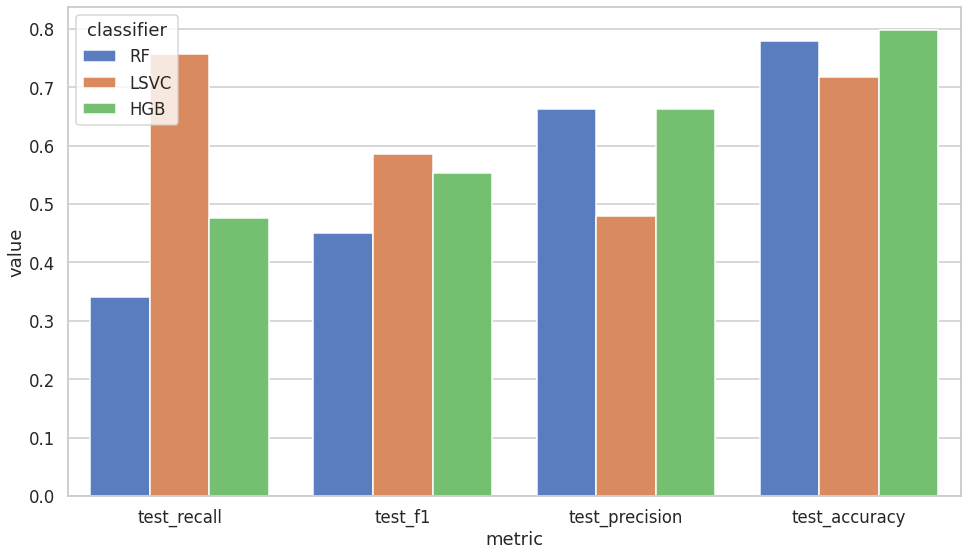

In [24]:
raw_results=pd.concat([RF_scores_df, LSVC_scores_df, HGB_scores_df], axis=1)

#Rearrange the results in a clearer dataframe
def pivot(dfr):
    data = {
        "value": np.delete(dfr.to_numpy().ravel(),range(6)),                    #flatten the array, throw away the timings
        "metric": np.asarray(['test_recall', 'test_f1', 'test_precision', 'test_accuracy']).repeat(3),
        "classifier": np.tile(['RF', 'LSVC', 'HGB'], 4)
    }
    return pd.DataFrame(data, columns=["classifier", "metric", "value"])

results=pivot(raw_results)

#visualize data
sns.barplot(data=results, x='metric', y='value', hue='classifier')
plt.show()

From the ``test_`` scores we can see that the three models behave quite differently: Random Forest has an abysmal Recall but good Precision and Accuracy, LinearSVC has the highest Recall and the lowest Accuracy, HistoGradBoost is the best in Accuracy but like RF is not great in Recall.

While the difference in Accuracy might seem unimportant, we have to be conscious that LinearSVC is almos 8% less effective at predicting our target flags than the other two, which is pretty unsustainable. Given its higher Recall and F1 scores, we'll pick the HGB model for our definitive fitting.

## 4.Fitting and results

Now we import and preprocess the test set as we did with the training:

In [25]:
#import data
raw_test=pd.read_csv('test_auto.csv',
                        index_col='INDEX',
                        false_values=['no', 'No', 'NO', 'z_No'],
                        true_values=['yes', 'Yes', 'YES']
                    )

#drop target columns, that are empty in this file
test_set=raw_test.drop(columns={'TARGET_AMT', 'TARGET_FLAG'}) 

#clean formatting
for sym in ['z_', '$', ',']:
    test_set = test_set.apply(lambda x: x.str.replace(sym, '') if x.dtype == object else x)

#Fix column categorization

to_numerical=['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']
for clmn in to_numerical:
    test_set[clmn]=test_set[clmn].astype(float)

to_category=['KIDSDRIV','HOMEKIDS','CLM_FREQ','SEX','JOB','EDUCATION','CAR_TYPE','CAR_USE','URBANICITY']
for clmn in to_category:
    test_set[clmn]=test_set[clmn].astype('category')

#Consolidate types
test_set=test_set.convert_dtypes()
test_set.info()

#get sample size
test_size, n_features = test_set.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2141 entries, 3 to 10300
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   KIDSDRIV    2141 non-null   category
 1   AGE         2140 non-null   Int64   
 2   HOMEKIDS    2141 non-null   category
 3   YOJ         2047 non-null   Int64   
 4   INCOME      2016 non-null   Int64   
 5   PARENT1     2141 non-null   boolean 
 6   HOME_VAL    2030 non-null   Int64   
 7   MSTATUS     2141 non-null   boolean 
 8   SEX         2141 non-null   category
 9   EDUCATION   2141 non-null   category
 10  JOB         2002 non-null   category
 11  TRAVTIME    2141 non-null   Int64   
 12  CAR_USE     2141 non-null   category
 13  BLUEBOOK    2141 non-null   Int64   
 14  TIF         2141 non-null   Int64   
 15  CAR_TYPE    2141 non-null   category
 16  RED_CAR     2141 non-null   boolean 
 17  OLDCLAIM    2141 non-null   Int64   
 18  CLM_FREQ    2141 non-null   category
 19  REVOK

In [26]:
column_transformer=make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_exclude='category')),
    (OneHotEncoder(drop='if_binary', sparse=False), make_column_selector(dtype_include='category'))
)

We fit our HGB model on the training set, then get a prediction based on the training to compare it to the test one:

In [27]:
#fit the model to the training set
model=make_pipeline(column_transformer, imputer, HGB)
model.fit(train_set, target_flags)

#get a prediction about the training set to compare it to the test prediction
flag_train_prediction=model.predict(train_set)
print(f"Positive predicted samples in training set: {100* flag_train_prediction.sum() / sample_size:.1f} %")

Positive predicted samples in training set: 20.5 %


Finally we get our predictions based on the test set and write them in a new csv file:

In [28]:
flag_test_prediction=model.predict(test_set)
np.savetxt('predicted_flags.csv', flag_test_prediction, fmt='%1d', delimiter=',', newline='\n')
print(f"Positive predicted samples in test set: {100* flag_test_prediction.sum() / test_size:.1f} %")

Positive predicted samples in test set: 19.2 %


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=50ad59a4-7a71-4cfa-9eac-20e7b12614b6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>